In [1]:
import pandas as pd
import janitor
from utilities import calculate_summary_statistics, save_mpl_fig

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

sns.set_theme(context="notebook", font_scale=1.35, style="white", palette="dark")

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib.lines as mlines
import matplotlib.patches as patches

## Prep

In [2]:
df = (
    pd.read_csv("../data/6.3m-ind-domain-data.csv.gz")
    .rename_column("visit_duration", "duration")
    .assign(
        duration_min=lambda df_: df_["duration"] / 60,
        duration_hr=lambda df_: df_["duration"] / 3600,
    )
    # ==================================================
    # Merge to VT
    .merge(
        (pd.read_csv("../data/yg_virustotal_dat.csv")),
        how="left",
        left_on="private_domain",
        right_on="filename",
        validate="m:1",
    )
    .assign(
        malicious_bool=lambda df_: np.where(df_["malicious"] >= 2, True, False),
        malicious_min=lambda df_: df_["malicious_bool"] * df_["duration_min"],
        malicious_hr=lambda df_: df_["malicious_bool"] * df_["duration_hr"],
        suspicious_bool=lambda df_: df_["suspicious"].astype("bool"),
    )
    # Winsorize duration
    .assign(
        duration=lambda df_: np.minimum(df_["duration"], df_["duration"].quantile(0.99))
    )
)
display(df.head())
df.info()

,caseid,private_domain,category,visit_time_local,duration,duration_min,duration_hr,filename,harmless,malicious,...,timeout,forcepoint,sophos,bitdefender,comodo,alphamnt,malicious_bool,malicious_min,malicious_hr,suspicious_bool
0,205323077,google.com,Search Engines and Portals,2022-05-31 23:52:37,2.0,0.033333,0.000556,google.com,70.0,0.0,...,0.0,search engines and portals,search engines,searchengines,NaN,NaN,False,0.0,0.0,False
1,205323077,coupons.com,"Business, Shopping",2022-06-01 01:07:35,451.0,7.616667,0.126944,coupons.com,68.0,0.0,...,0.0,shopping,online shopping,ads,NaN,"Marketing/Merchandising, Shopping",False,0.0,0.0,False
2,205323077,google.com,Business,2022-06-01 01:15:12,55.0,0.916667,0.015278,google.com,70.0,0.0,...,0.0,search engines and portals,search engines,searchengines,NaN,NaN,False,0.0,0.0,False
3,205323077,coupons.com,"Business, Shopping",2022-06-01 01:16:07,451.0,37.083333,0.618056,coupons.com,68.0,0.0,...,0.0,shopping,online shopping,ads,NaN,"Marketing/Merchandising, Shopping",False,0.0,0.0,False
4,205323077,google.com,Search Engines and Portals,2022-06-01 04:38:10,10.0,0.166667,0.002778,google.com,70.0,0.0,...,0.0,search engines and portals,search engines,searchengines,NaN,NaN,False,0.0,0.0,False


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6297382 entries, 0 to 6297381
Data columns (total 22 columns):
 #   Column            Dtype  
---  ------            -----  
 0   caseid            int64  
 1   private_domain    object 
 2   category          object 
 3   visit_time_local  object 
 4   duration          float64
 5   duration_min      float64
 6   duration_hr       float64
 7   filename          object 
 8   harmless          float64
 9   malicious         float64
 10  suspicious        float64
 11  undetected        float64
 12  timeout           float64
 13  forcepoint        object 
 14  sophos            object 
 15  bitdefender       object 
 16  comodo            object 
 17  alphamnt          object 
 18  malicious_bool    bool   
 19  malicious_min     float64
 20  malicious_hr      float64
 21  suspicious_bool   bool   
dtypes: bool(2), float64(10), int64(1), object(9)
memory usage: 1021.0+ MB


In [3]:
df["duration"].quantile(0.95)

125.0

In [4]:
df["duration"].quantile(0.99)

451.0

In [5]:
df["duration"].quantile(0.95)

125.0

In [6]:
df["duration"].quantile(0.99)

451.0

In [7]:
df["duration"].describe(
    percentiles=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]
)

count    6.297382e+06
mean     2.780000e+01
std      6.323316e+01
min      0.000000e+00
50%      7.000000e+00
60%      1.100000e+01
70%      1.700000e+01
80%      3.000000e+01
90%      6.600000e+01
95%      1.250000e+02
96%      1.500000e+02
97%      1.870000e+02
98%      2.500000e+02
99%      4.510000e+02
max      4.510000e+02
Name: duration, dtype: float64

In [8]:
df_mal_visits = (
    df.query("malicious>0").reset_index(drop=True)
    #     .assign(
    #         duration=lambda df_: np.minimum(
    #             df_["duration"], df_["duration"].quantile(0.99)
    #         )
    #     )
    # bin those > 12 to be 12
    .assign(malicious=lambda df_: np.minimum(12, df_["malicious"]))
)
# assert (df_mal_visits["duration_min"] == df_mal_visits["malicious_min"]).all()
display(df_mal_visits.head(3))
df_mal_visits.info()

,caseid,private_domain,category,visit_time_local,duration,duration_min,duration_hr,filename,harmless,malicious,...,timeout,forcepoint,sophos,bitdefender,comodo,alphamnt,malicious_bool,malicious_min,malicious_hr,suspicious_bool
0,205323077,gmail.co,NaN,2022-06-11 18:24:08,1.0,0.016667,0.000278,gmail.co,66.0,1.0,...,0.0,general email,NaN,im,NaN,NaN,False,0.0,0.0,False
1,205323077,gmail.com,Chat and Instant Messaging,2022-06-11 18:24:09,6.0,0.100000,0.001667,gmail.com,69.0,1.0,...,0.0,general email,web e mail,webmail,NaN,NaN,False,0.0,0.0,False
2,205323077,aboutamazon.com,Business,2022-06-13 12:19:13,271.0,4.516667,0.075278,aboutamazon.com,68.0,1.0,...,0.0,business and economy,NaN,news,NaN,"Business/Economy, News",False,0.0,0.0,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155671 entries, 0 to 155670
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   caseid            155671 non-null  int64  
 1   private_domain    155671 non-null  object 
 2   category          108472 non-null  object 
 3   visit_time_local  155671 non-null  object 
 4   duration          155671 non-null  float64
 5   duration_min      155671 non-null  float64
 6   duration_hr       155671 non-null  float64
 7   filename          155671 non-null  object 
 8   harmless          155671 non-null  float64
 9   malicious         155671 non-null  float64
 10  suspicious        155671 non-null  float64
 11  undetected        155671 non-null  float64
 12  timeout           155671 non-null  float64
 13  forcepoint        142127 non-null  object 
 14  sophos            121894 non-null  object 
 15  bitdefender       96754 non-null   object 
 16  comodo            13

In [9]:
percentiles = [5, 10, 25, 50, 75, 90, 95]
summ = (
    calculate_summary_statistics(
        df_mal_visits,
        groupby_column="malicious",
        value_column="duration",
        percentiles=percentiles,
    )
    .sort_values("malicious", ignore_index=True)
    .assign(
        count=lambda df: df["count"].str.replace(
            r"(\d+)", lambda x: "{:,}".format(int(x.group(1))), regex=True
        )
    )  # Format count with thousands separator
    .applymap(
        lambda x: "{:,.0f}".format(x) if isinstance(x, (int, float)) else x
    )  # Format other numeric columns
    .assign(count=lambda x: x["count"].str.replace(r"\\%", "%", regex=True))
)
summ

,malicious,count,mean,std,min,5,10,25,50,75,90,95,max
0,1,"131,994 (84.8%)",32,84,0,1,1,1,5,16,65,197,451
1,2,"13,357 (8.6%)",22,60,0,0,1,1,4,15,47,101,451
2,3,"2,940 (1.9%)",30,80,0,0,1,1,3,15,70,178,451
3,4,"1,476 (0.9%)",18,45,0,0,1,1,5,15,39,81,451
4,5,881 (0.6%),16,46,0,0,1,1,3,12,36,55,451
5,6,"2,793 (1.8%)",29,66,0,1,1,2,6,22,67,152,451
6,7,207 (0.1%),11,23,0,0,0,1,3,9,30,60,126
7,8,538 (0.3%),21,43,0,1,1,2,9,23,43,70,451
8,9,548 (0.4%),37,85,0,1,1,1,7,23,105,194,451
9,10,201 (0.1%),26,53,0,0,1,1,10,32,59,85,451


In [10]:
nonmal_mean = df.query("malicious==0").query("suspicious==0")["duration"].mean()
nonmal_median = df.query("malicious==0").query("suspicious==0")["duration"].median()

## Plot

            values
count  1000.000000
mean     56.878871
std      36.627325
min       7.880073
25%      32.232438
50%      47.332930
75%      70.540963
max     256.630183


(array([16., 28., 61., 67., 92., 83., 83., 76., 65., 55., 67., 43., 26.,
        27., 35., 27., 18., 21.,  9., 10., 13.,  8., 11.,  5.,  2.,  7.,
         7.,  2.,  5.,  4.,  3.,  4.,  1.,  3.,  1.,  1.,  4.,  1.,  2.,
         2.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.]),
 array([  7.88007304,  12.85507525,  17.83007746,  22.80507966,
         27.78008187,  32.75508408,  37.73008629,  42.7050885 ,
         47.68009071,  52.65509292,  57.63009513,  62.60509734,
         67.58009955,  72.55510176,  77.53010397,  82.50510617,
         87.48010838,  92.45511059,  97.4301128 , 102.40511501,
        107.38011722, 112.35511943, 117.33012164, 122.30512385,
        127.28012606, 132.25512827, 137.23013047, 142.20513268,
        147.18013489, 152.1551371 , 157.13013931, 162.10514152,
        167.08014373, 172.05514594, 177.03014815, 182.00515036,
        186.98015257, 191.95515477, 196.93015698, 201.90515919,
        206.8801614 , 211.85516361, 216.83016582, 221.80516803,
        226.

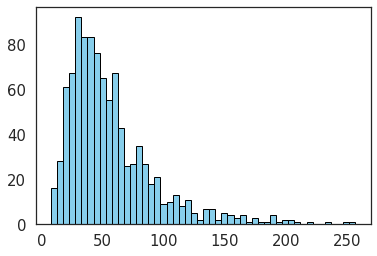

In [11]:
# Prep data for legend
# Parameters for the log-normal distribution
np.random.seed(0)
n = 1000
mean = 50
std_dev = 10
# Generate moderately skewed data
mu = np.log(mean) - 0.5 * (std_dev / mean) ** 2  # Adjusted mean for log-normal
sigma = 0.6  # Reduced sigma for moderate skewness
data = np.random.lognormal(mean=mu, sigma=sigma, size=n)
df_leg = pd.DataFrame(data, columns=["values"])

print(df_leg.describe())

plt.hist(df_leg["values"], bins=50, color="skyblue", edgecolor="black")

In [12]:
def add_arrow(head_pos, tail_pos, ax):
    style = "Simple, tail_width=0.05, head_width=7.0, head_length=7.0"
    kw = dict(arrowstyle=style, color="k", linewidth=0.2)
    arrow = patches.FancyArrowPatch(
        tail_pos, head_pos, connectionstyle="arc3,rad=0.2", **kw
    )
    ax.add_patch(arrow)

In [13]:
yticklabels = [
    "1 flag",
    "2 flags",
    "3 flags",
    "4 flags",
    "5 flags",
    "6 flags",
    "7 flags",
    "8 flags",
    "9 flags",
    "10 flags",
    "11 flags",
    "12\u201417 flags",
]

In [14]:
# darkgreen = '#9BC184'
# midgreen = '#C2D6A4'
# lightgreen = '#E7E5CB'
# colors = [lightgreen, midgreen, darkgreen, midgreen, lightgreen]
# dark = "#7fc1c4"
# mid = "#a4e2d3"
# light = "#d8fbd4"
# esox lucius
dark = "#837963"
mid = "#939387"
light = "#e1e2dd"
colors = [light, mid, dark, mid, light]

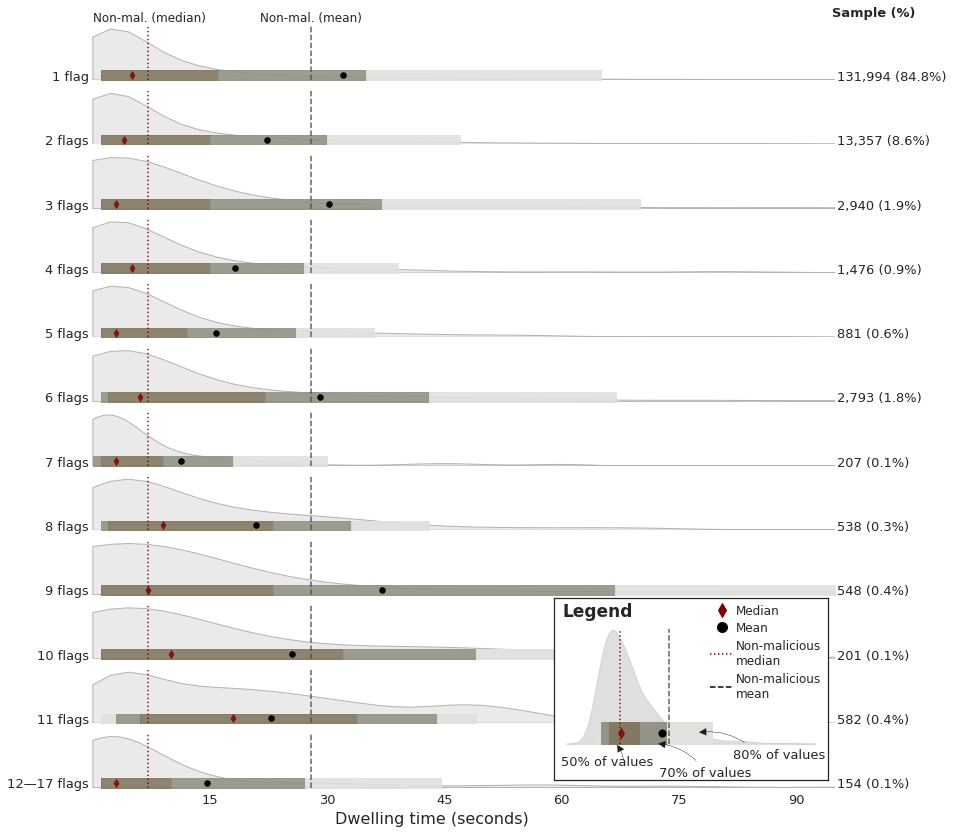

In [15]:
# plot
flags = range(1, 13)
x = "duration"

_scale = 1.4
_aspect_ratio = (10, 10)
figsize = tuple(k * _scale for k in _aspect_ratio)
fig, axs = plt.subplots(nrows=len(flags), ncols=1, figsize=figsize)
axs = axs.flatten()

for ix, n_flags in enumerate(flags):
    df_subset = df_mal_visits.query(f"malicious=={n_flags}")

    sns.kdeplot(
        df_subset[x],
        shade=True,
        bw_adjust=0.5,
        cut=0,
        color=".8",
        alpha=0.4,
        edgecolor=".7",
        ax=axs[ix],
    )

    # ==========================================================
    axs[ix].set_xlim(-5, 95)
    axs[ix].set_ylim(0, axs[ix].get_ylim()[1])
    axs[ix].set_ylabel("")
    axs[ix].set_xlabel("")
    axs[ix].axis("off")

    # ==========================================================
    # global non-mal mean/median as a references
    axs[ix].axvline(nonmal_mean, linestyle="--", alpha=0.9, color="#525252")
    axs[ix].axvline(nonmal_median, linestyle="dotted", alpha=0.9, color="maroon")

    # ==========================================================
    # percentiles
    percentiles = [10, 15, 25, 75, 85, 90]
    quantiles = np.percentile(df_subset[x], percentiles)
    quantiles = quantiles.tolist()

    # Plot
    quantile_bar_height = 0.18
    for j in range(len(quantiles) - 1):
        # Get the axis limits
        y_min, y_max = axs[ix].get_ylim()

        # Define relative y-coordinates (e.g., proportional to the plot height)
        y_lower = 0.0  # Bottom of the plot (relative 0)
        y_upper = (
            quantile_bar_height * (y_max - y_min) + y_min
        )  # 2% of the total y-range, scaled back to absolute

        # Fill between quantiles with relative y-coordinates
        axs[ix].fill_between(
            [quantiles[j], quantiles[j + 1]],  # Lower bound  # Upper bound
            y_lower,  # Relative lower bound
            y_upper,  # Relative upper bound
            color=colors[j],
            alpha=0.9,
        )

    # ==========================================================
    # Medians
    median = df_subset[x].median()
    axs[ix].scatter(
        [median],  # Absolute x-coordinate
        [quantile_bar_height / 2],  # Relative y-coordinate
        color="maroon",
        marker="d",
        alpha=0.8,
        s=30,
        transform=axs[ix].get_xaxis_transform(),  # Use a mixed transformation
    )

    # ==========================================================
    # means
    mean = df_subset[x].mean()
    axs[ix].scatter(
        [mean],  # Absolute x-coordinate
        [quantile_bar_height / 2],  # Relative y-coordinate
        color="black",
        s=30,
        transform=axs[ix].get_xaxis_transform(),  # Use a mixed transformation
    )

    # ==========================================================
    # yticklabel 1
    axs[ix].text(
        -0.5,
        0,
        yticklabels[ix],
        ha="right",
        fontsize=13,
        color=".15",
    )

    # ==========================================================
    # yticklabel 2
    #     sample_count_text = summ.query(f"malicious=='{n_flags}'")["count"].values[0]
    #     axs[ix].text(
    #         -5, 0,
    #         f'{sample_count_text}',
    #         ha='right',
    #         fontsize=12,
    # #         fontproperties=fira_sans_regular,
    #         color=".15",
    #     )

    # yticklabel 2 - left side
    sample_count_text = summ.query(f"malicious=='{n_flags}'")["count"].values[0]
    axs[ix].text(
        95.3,
        0,
        f"{sample_count_text}",
        ha="left",
        fontsize=13,
        color=".15",
    )

    # x axis scale for last ax
    if ix == 11:
        values = range(15, 100, 15)
        for value in values:
            axs[ix].text(
                value,
                -0.005,
                f"{value}",
                ha="center",
                va="top",
                fontsize=13,
            )

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# right y-tick title
fig.text(
    x=0.98,
    y=0.89,
    s="Sample (%)",
    ha="right",
    fontweight="bold",
    fontsize=13,
    color=".15",
)

# x axis label
fig.text(
    x=0.5,
    y=0.09,  # Relative placement in figure space
    s="Dwelling time (seconds)",
    ha="center",
    fontsize=16,
    transform=fig.transFigure,
)

# Non-mal mean label
fig.text(
    x=0.38,
    y=0.885,
    s="Non-mal. (mean)",
    ha="center",
    fontsize=12,
)
# Non-mal median label
fig.text(
    x=0.22,
    y=0.885,
    s="Non-mal. (median)",
    ha="center",
    fontsize=12,
)

# ---------------------------------------------------
subax = inset_axes(
    parent_axes=axs[-1],
    width="35%",
    height="340%",
    loc="lower right",
)
subax.set_xticks([])
subax.set_yticks([])
sns.kdeplot(df_leg["values"], shade=True, ax=subax, color="grey", edgecolor="lightgrey")

subax.set_ylim(-0.005, 0.02)

quantiles = np.percentile(df_leg["values"], [2.5, 10, 25, 75, 90, 97.5])
quantiles = quantiles.tolist()
for j in range(len(quantiles) - 1):
    subax.fill_between(
        [quantiles[j], quantiles[j + 1]],  # lower bound  # upper bound
        0,  # max y=0
        #         0.00004, # max y=0.00004
        0.003,  # max y=0.00004
        color=colors[j],
    )

# -------------------------------------------
mean = df_leg["values"].mean()
subax.scatter([mean + 40], [0.0015], color="black", s=50)
# subax.text(
#     mean+50+40, 0.01,
#     'Mean',
#     ha='center',
#     fontsize=15,
#     #fontproperties=fira_sans_regular
# )
# add_arrow((mean+40, .002), (mean+40+30, .01-.001), subax)

# -------------------------------------------
median = df_leg["values"].median()
subax.scatter(
    [median],
    [0.0015],
    color="maroon",
    marker="d",
    alpha=0.8,
    s=50,
)
# subax.text(
#     median-15, 0.015,
#     'Median',
#     ha='center',
#     fontsize=15,
#     #fontproperties=fira_sans_regular
# )
# -------------------------------------------
# 80% indicator
subax.text(
    240,
    -0.002,
    "80% of values",
    ha="center",
    fontsize=13,
)
add_arrow((140, 0.0015), (200, -0.00), subax)
# 70% indicator
subax.text(
    150,
    -0.0045,
    "70% of values",
    ha="center",
    fontsize=13,
)
add_arrow((90, 0.00), (140, -0.0025), subax)
# 50% indicator
subax.text(
    30,
    -0.003,
    "50% of values",
    ha="center",
    fontsize=13,
)
add_arrow((40, 0.00), (50, -0.0025), subax)

subax.axvline(x=105, ymin=0.2, ymax=0.83, linestyle="--", alpha=0.9, color="#525252")
subax.axvline(x=45, ymin=0.2, ymax=0.83, linestyle="dotted", alpha=0.9, color="maroon")

# Legend title
subax.text(
    -25,
    0.0175,
    "Legend",
    ha="left",
    fontsize=17,
    fontweight="bold",
)

maroon_diamond = mlines.Line2D(
    [], [], color="maroon", marker="d", linestyle="None", markersize=10, label="Median"
)
black_circle = mlines.Line2D(
    [], [], color="black", marker="o", linestyle="None", markersize=10, label="Mean"
)
maroon_dotted_line = mlines.Line2D(
    [], [], color="maroon", linestyle=":", label="Non-malicious\nmedian"
)
black_dashed_line = mlines.Line2D(
    [], [], color="black", linestyle="--", label="Non-malicious\nmean"
)

# Add the legend
subax.legend(
    handles=[maroon_diamond, black_circle, maroon_dotted_line, black_dashed_line],
    loc="upper right",
    fontsize=12,
    frameon=False,
    handletextpad=0.2,
    labelspacing=0.4,
    borderaxespad=0.1,
)

save_mpl_fig("../figs/kde-maliciousness-duration")

In [16]:
len(df.query("malicious>0"))

155671

In [17]:
len(df.query("malicious>1"))

23677

In [18]:
len(df.query("malicious==0").query("suspicious==0"))

6002879